In [ ]:
!pip install segmentation-models-pytorch
# !pip install -U git+https://github.com/albumentations-team/albumentations

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 3.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 11.8 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_6

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
import torch
import torch.nn as nn
import segmentation_models_pytorch as smp
from torchvision import transforms
from PIL import Image
import numpy as np
import h5py
from pylab import imshow, show
from tensorflow.keras.models import load_model
import tensorflow as tf

In [ ]:
class SegmentationModel(nn.Module):
    def __init__(self):
        super(SegmentationModel, self).__init__()
        self.arc = smp.Unet(
            encoder_name='timm-efficientnet-b1',
            encoder_weights='imagenet',
            in_channels=3,
            classes=1,
            activation=None
        )

    def forward(self, images, masks=None):
        logits = self.arc(images)
        if masks is not None:
            loss1 = smp.losses.DiceLoss(mode='binary')(logits, masks)
            loss2 = nn.BCEWithLogitsLoss()(logits, masks)
            return logits, loss1 + loss2
        return logits

In [ ]:
# Load the segmentation model
segmentation_model = SegmentationModel()
segmentation_model.load_state_dict(torch.load('/content/drive/MyDrive/Sclera_dataset/best_model_timm-efficientnet-b1.pt'))
segmentation_model.eval()


SegmentationModel(
  (arc): Unet(
    (encoder): EfficientNetEncoder(
      (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn1): BatchNormAct2d(
        32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
        (drop): Identity()
        (act): Swish()
      )
      (blocks): Sequential(
        (0): Sequential(
          (0): DepthwiseSeparableConv(
            (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (bn1): BatchNormAct2d(
              32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
              (drop): Identity()
              (act): Swish()
            )
            (se): SqueezeExcite(
              (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
              (act1): Swish()
              (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
              (gate): Sigmoid()
            )
           

In [ ]:
# Load the Keras classifier model
keras_classifier_model = load_model('/content/drive/MyDrive/Sclera_dataset/effib0final.keras')

In [ ]:
def overlay_mask(image, mask, alpha=0.5):
    """Overlay mask on image."""
    image = image.numpy().transpose(1, 2, 0)
    mask = mask.numpy().transpose(1, 2, 0)
    overlay = image*mask
    overlay=(1-alpha)*image+alpha*overlay
    return overlay

def predict(image_path):
    # Load and preprocess the image
    image = Image.open(image_path)
    preprocess = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor()
    ])
    input_tensor = preprocess(image).unsqueeze(0)
    # print(input_tensor.shape)


    # Perform segmentation
    with torch.no_grad():
        output = segmentation_model(input_tensor)
    pred_mask = torch.sigmoid(output)
    pred_mask = (pred_mask > 0.5) * 1.0
    # print(f'pred {pred_mask.max()}')
    # print(f'pred {pred_mask.min()}')
    # pred_mask = pred_mask.squeeze().numpy()
    input_tensor = input_tensor.view(3, 256, 256)  # Use view to reshape
    pred_mask = pred_mask.view(1, 256, 256)  # Use view to reshape
    # input_tensor=input_tensor/255.0
    # # Save the segmented image
    # # Convert the segmented mask to an image
    segmented_img = overlay_mask(input_tensor, pred_mask)
    segmented_img_pil = Image.fromarray((segmented_img * 128).astype(np.uint8))
    display(segmented_img_pil)
    # print(segmented_img.shape)
    # print(segmented_img.max())
    # print(segmented_img.min())
    # segmented_img.save(image_path
    # output_path = '/content/drive/MyDrive/new_segg'
    # segmented_img.save(os.path.join(output_path, image_path))
    # # Preprocess the segmented image for Keras model
    # segmented_img = segmented_img.resize((256, 256))  # Assuming Keras model input size is 224x224
    # segmented_img_array = np.array(segmented_img) / 255.0  # Normalize to [0, 1]
    segmented_img_array = np.expand_dims(segmented_img_pil, axis=0)  # Add batch dimension

    # # Classify the segmented image
    prediction = keras_classifier_model.predict(segmented_img_array)[0][0]

    # # Determine if jaundice is present
    jaundice_present = prediction > 0.5
    return (jaundice_present,prediction)



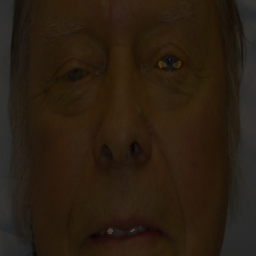

1/1 [==============================] - 0s 111ms/step
Jaundice is present


1.0

In [ ]:
# Example usage:
path='/content/know_jaundice_slide-1.jpg'
ans,pre=predict(path)
if(ans==True):
  print("Jaundice is present")
else:
  print("Jaundice is not present")
pre